# Star Sky Simulation

1. [Generate the field](#i-part-generate-the-field)
    1. [First Cell](#first-cell)
    2. [Second and Third Cell](#second-and-third-cells)
    3. [Fourth Cell](#fourth-cell)
    4. [Fifth Cell](#fifth-cell)

---

## I part: generate the field

### First cell

I defined the parameters like the dimension of the field, the number of stars, the exponents of the potential laws and the IMF function

In [261]:
# FIRST CELL
##* packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import os

# dimension of the matrix
N = int(1e2)
# number of stars
M = int(1e1)

## Set parameters
alpha = 2
beta  = 3
# minimum and maximum masses 
m_min = 0.1; m_max = 20
# Initial Mass Function
IMF = lambda m : m**(-alpha)
# def IMF(m):
#     if(m >= 0.01 and m < 0.08):
#         a = -0.3
#     elif(m >= 0.08 and m < 0.5 ):
#         a = -1.3
#     else:
#         a = -2.3
#     return m**a
IMF_min = IMF(0.1); IMF_max = IMF(20) 

print(f'IMF for smallest and biggest stars:\nM\t\tIMF\n0.1 Msun\t{IMF_min}\n20  Msun\t{IMF_max}')


IMF for smallest and biggest stars:
M		IMF
0.1 Msun	99.99999999999999
20  Msun	0.0025


### Second and Third cells
I defined the function for the random generation of the masses and then I created the luminosity array

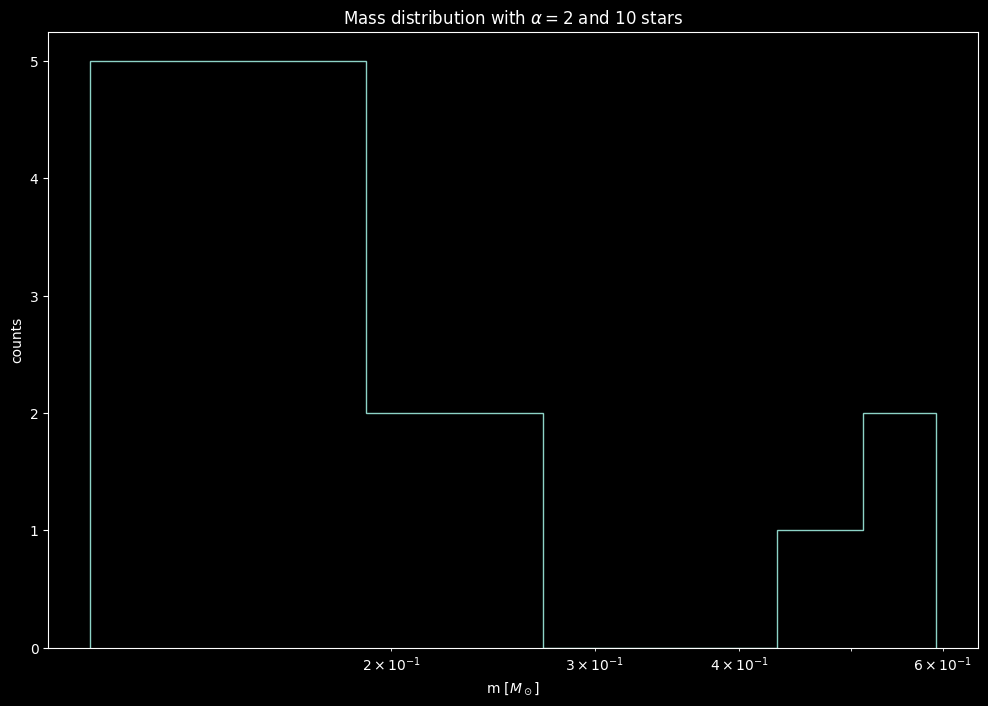

In [262]:
# SECOND CELL

# Current directory
pwd = os.getcwd()

##* 
def generate_mass_array(imf_min : float ,imf_max : float ,sdim : int = M) -> np.ndarray:
    """Genration of masses array with IMF distribution
    The function takes the minimum and the maximum of the
    IMF, generates a M-dimension array of random value for imf in
    [IMF_min,IMF_max] and returns a M-dimension array of masses,
    distribuited like the IMF

    :param imf_min: minimum imf value
    :type imf_min: float
    :param imf_max: maximum imf value
    :type imf_max: float
    :param sdim: number of stars, defaults to M
    :type sdim: int, optional

    :return: {dim} array of masses distributed like imf
    :rtype: np.ndarray
    """
    np.random.seed()
    return (np.random.rand(sdim)*(imf_min-imf_max)+imf_max)**(-1/alpha)
    # imf_trs = IMF(0.5)
    #dim = int(sdim/2)
    # imf1 = np.random.rand(dim)*(imf_trs-imf_max)+imf_max
    # imf1 = imf1**(-1/2)
    # imf2 = np.random.rand(dim)*(imf_min-imf_trs)+imf_min
    # imf2 = imf2**(-1/2)
#    return np.append(imf1,imf2)

# M array of masses in solar mass unit
m = generate_mass_array(IMF_min,IMF_max)

## Plot data

plt.figure(figsize=(12,8))
plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.hist(m,int(3*M/5),histtype='step')
plt.xscale('log')
#plt.xlim(0.09,20)
plt.xlabel('m [$M_\odot$]')
plt.ylabel('counts')


plt.show()



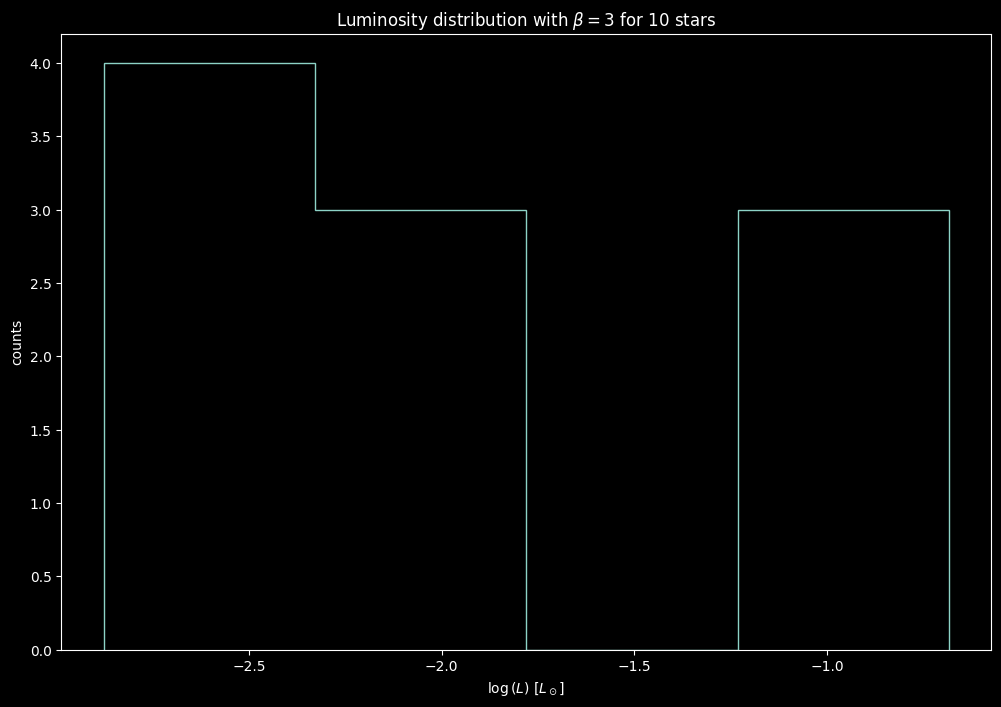

In [263]:
# THIRD CELL
# M array of luminosities in solar luminosity unit
L = m**beta

## Plot data
plt.figure(figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.hist(np.log10(L),int(2*M/5),histtype='step')
#plt.xlim(np.log10(0.09)*beta,np.log10(20)*beta)
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')

plt.show()

### Fourth cell
I defined the star class object, a class that contains all infos about star (mass,lum and position) and I implemented the function to set stars positions and the function to update the field matrix with the stars luminosities in mag. 
Since the function `plt.imshow()` takes float values from 0 to 1 to generate an image in grayscale, I decided to write the `transfer_function()`, that transforms luminosities into values in [0,1].

In [264]:
# FOURTH CELL
##* Star class obj to collect star informations
class star(object):
#        param    mass    star mass
#        param    lum    star luminosity
#         param    x,y     star coordinates in the field     
    def __init__(self,mass, lum, x ,y):
        self.m   = mass        # star mass value
        self.lum = lum        # star luminosity value
        self.x = x        # star x coordinate
        self.y = y        # star y coordinate

##* 
#? I have to check this function: the condition replace=False forbids M > N  
def star_location(sdim : int = M,dim : int = N) -> tuple:
    """Function to locate the stars
    It generates 2 random arrays of dimension n: 
    one is the x coordinate array and 
    y coordinate array of each star

    :param sdim: number of stars, defaults to M
    :type sdim: int, optional
    :param dim: dimension of the field, defaults to N
    :type dim: int, optional

    :return: tuple of star coordinates arrays
    :rtype: tuple
    """
    tmp = np.random.default_rng()
    X = tmp.choice(dim, size=sdim)
    Y = tmp.choice(dim, size=sdim)#, replace=False)
    return X, Y    




##* 
def update_field(F : np.ndarray,pos : tuple, lum : np.ndarray) -> np.ndarray:
    """Function to update the field
    It adds the generated stars to the field
    The shape of the field matrix is discussed
    in the next cell

    :param F: field matrix [dim,dim]
    :type F: np.ndarray
    :param pos: tuple of star coordinates arrays
    :type pos: tuple
    :param lum: luminosity array
    :type lum: np.ndarray
    :return: updated field matrix [dim,dim]
    :rtype: np.ndarray
    """
    X, Y = pos
    F[X,Y] += lum
    return F


##*   
def field_image(fig, image, F: np.ndarray, v : int = 0,sct : tuple = (0,-1)) -> None:
    """Function to represent the field
    It shows the field. It is possible to selected
    a section of the field using the parameter sct 

    :param image: matplotlib object
    :type image: _type_
    :param F: field matrix
    :type F: np.ndarray
    :param v: set the color of the image, defaults to 0.
            *  1 for viridis
            *  0 for grayscale
            * -1 for inverse grayscale
    :type v: int, optional
    :param sct: selected square section of the field, defaults to [0,-1]
    :type sct: tuple, optional
    """
    # lum = transfer_function(F)
    # lum = v*(lum-1) + (1+v)*lum
    a,b = sct
    if v == 0: color = 'gray'
    elif v == 1: color = 'viridis' 
    else: color = 'gray_r' 
    pic = image.imshow(F[a:b,a:b], cmap=color, norm='log')
    fig.colorbar(pic, ax=image, cmap=color, norm='log', location='bottom')

##* Transfer function
#?  Understand if it is reasonable 
'''   
    The implementation of this function is my choice. The function plt.imshow() takes float values in [0,1] to make grayscale image.
    I decided to convert luminosities into values in [0,1], using logaritmic values of them: 
        - I set a minimum detectable value of luminosity (called inf)
          Luminosities < inf are represented as black pixels
        - I normaled with the maximum value of luminosity (called sup)
          Luminosities = sup are converted in 1 (namely white)
'''
#   It converts luminosities in a scale from 0 to 1 to get grayscale
#   with function plt.imshow()
#     param    l    array of luminosities
# 
#     return    mag    converted magnitudes array   
# def transfer_function(l):
#     inf = 9e-5    # threshold to detect luminosity
#     sup = 8000    # maximum luminosity
#     # control the presence of 0s, change them with inf and save in an other temporary array
#     tmp = np.where(l<=0,inf,l)
#     # convertion
#     mag = (np.log10(tmp)-np.log10(inf)) / (np.log10(sup)-np.log10(inf))
#     # control the presence of negative values in mag and change them with 0
#     mag = np.where(mag<0,0,mag); mag = np.where(mag>1,1,mag)
#     return mag


    

'   \n    The implementation of this function is my choice. The function plt.imshow() takes float values in [0,1] to make grayscale image.\n    I decided to convert luminosities into values in [0,1], using logaritmic values of them: \n        - I set a minimum detectable value of luminosity (called inf)\n          Luminosities < inf are represented as black pixels\n        - I normaled with the maximum value of luminosity (called sup)\n          Luminosities = sup are converted in 1 (namely white)\n'

### Fifth cell
I implemented the initialization function to generate the masses, the field and the image without any psf or noise.

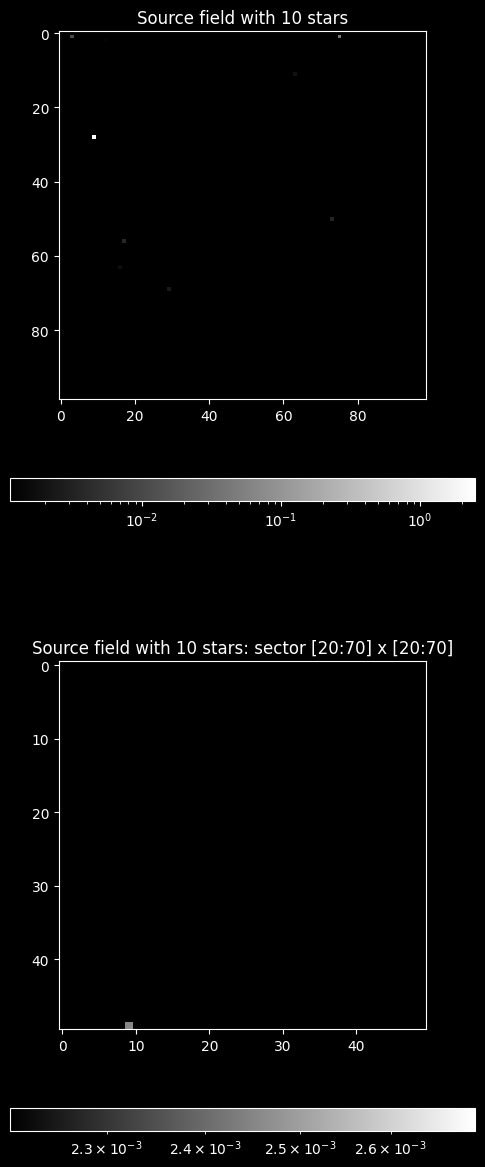

In [265]:
# FIFTH CELL

def check_field(field : np.ndarray) -> np.ndarray:
    """Check the presence of negative values
    The function finds possible negative values
    and substitutes them with 0.0

    :param field: field matrix
    :type field: ndarray

    :return: checked field matrix
    :rtype: ndarray
    """
    return np.where(field < 0, 0.0, field)


##* 
def initialize(dim : int = N, sdim : int = M) -> tuple:
    """Initialization function: generation of the "perfect" sky
    It generates the stars and initialized the field to make
    the sky image without any psf and noise

    :param dim: dimension of the field, defaults to N
    :type dim: int, optional
    :param sdim: number of stars, defaults to M
    :type sdim: int, optional
    :return: tuple of the field matrix F and :class: `star` object with all the informations
    :rtype: tuple
    """
    # generate a [N,N,3] matrix of 0s
    # the third index is use for the RGB
    F = np.zeros([dim,dim])
    # generate masses
    m = generate_mass_array(IMF_min,IMF_max)
    # set luminosities
    L = m**beta
    # generate stars coordinates
    xs,ys = star_location(sdim)
    # put stars in the field
    F = check_field(update_field(F,(xs,ys),L))
    # save stars infos
    S = star(m,L,xs,ys)
    return F, S

# generation of the field and the stars
F, S = initialize()

## Plot
# variables to zoom a sector [inf:sup] x [inf:sup] of the field
inf = int(0.2*N)
sup = int(0.7*N)

fig, axs = plt.subplots(2, 1, figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = 0

img_field, img_zoom = axs

field_image(fig, img_field,F,v)
#img_field.imshow(1-F)
img_field.set_title(f'Source field with {M} stars')
field_image(fig, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'Source field with {M} stars: sector [{inf}:{sup}] x [{inf}:{sup}]')

plt.show()

### Sixth cell
I implemented the function for the atmosferic seeing by gaussian distribution

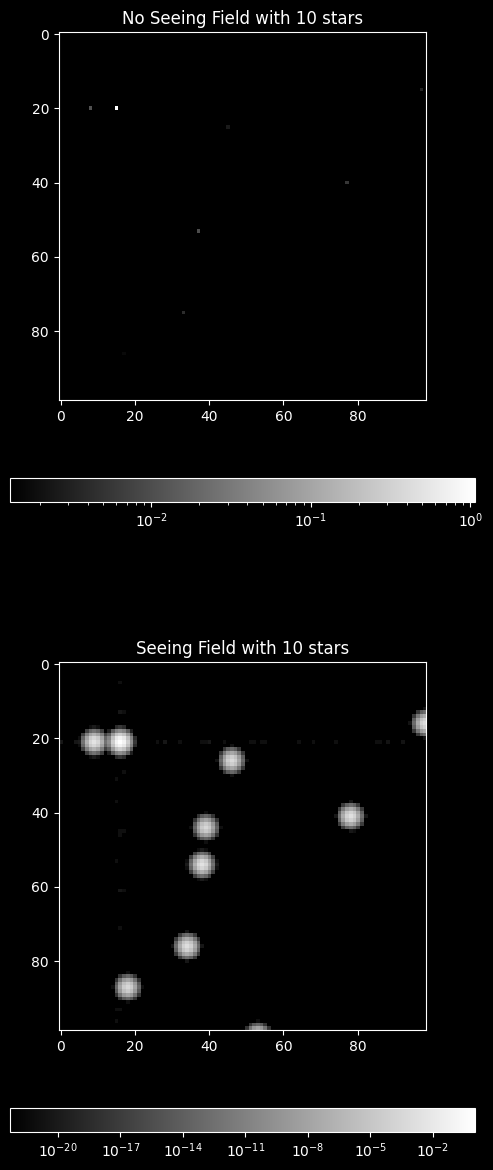

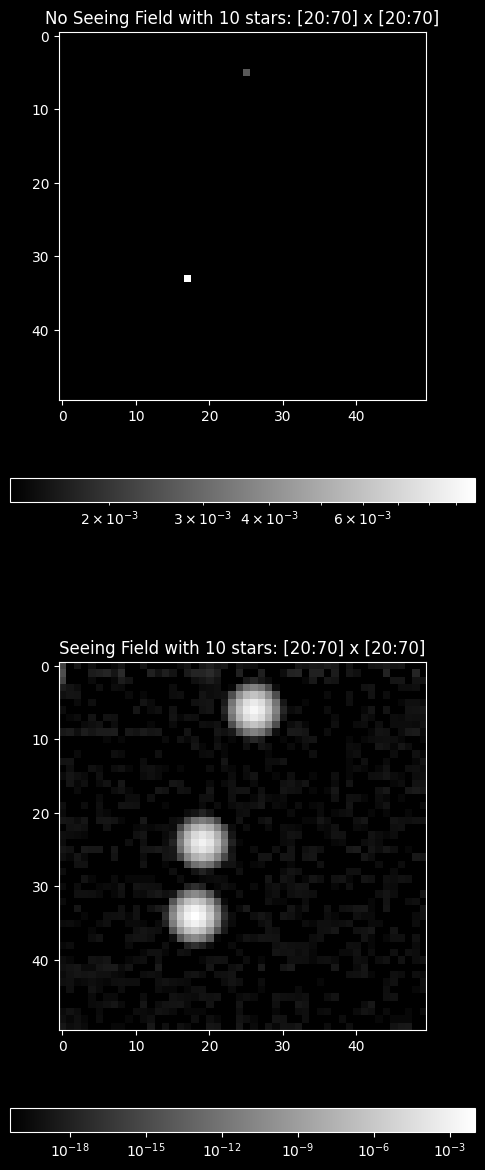

In [266]:
# SIXTH CELL
##* 
def gaussian(sigma : float = 0.5,dim : int = N) -> np.ndarray:
    """Gaussian matrix generator
    It makes a gaussian [dim,dim] matrix, centered in (0,0)

    :param sigma: the root of variance, defaults to 0.5
    :type sigma: float, optional
    :param dim: size of the field, defaults to N
    :type dim: int, optional
    
    :return: gaussian [dim,dim] matrix
    :rtype: np.ndarray
    """
    x = np.arange(dim, dtype=int)
    y = np.arange(dim, dtype=int)
    # shift to center of the field
    x -= int(dim/2);  y -= int(dim/2)
    # Gaussian function
    G = lambda r : np.exp(-r**2/sigma**2/2)
    # generate [dim,dim] matrix = G_i * G_j
    return np.outer(G(x),G(y))


##* 
#?  Add a parameter to choose atm pfs between Gaussian and Lorentzian
def atm_seeing(f):
    """Atmosferic seeing function
    It convolves the field with tha Gaussian to
    make the atmosferic seeing

    :param f: field matrix
    :type f: Any
    
    :return: field matrix with seeing
    :rtype: Any
    """
    # dim of the field
    n = len(f)
    # call f_s the new field with seeing
#    f_s = f
    # take [n,n] matrix from the field
    field = f
    # convolution with gaussian
    field = fftconvolve(field, gaussian(dim=n), mode='same')
    # values are saved in each color channel 
    # to have grayscale
    return check_field(field)

# generation of the field and the stars
F, S = initialize()

## Plot
fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, (img_zoom, img_zoom_seeing)   = plt.subplots(2,1,figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = 0

field_image(fig1, img_field,F,v)
#img_field.imshow(1-F)
img_field.set_title(f'No Seeing Field with {M} stars')
field_image(fig1, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'No Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

# generation of the seeing image
F_s = atm_seeing(F)
field_image(fig2, img_field_seeing,F_s,v)
#img_field_seeing.imshow(1-F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
#img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

picdir = os.path.join(pwd,'Pictures')
fig1.savefig(os.path.join(picdir,'field.png'))
fig2.savefig(os.path.join(picdir,'zoom.png'))

plt.show()
    
    

### Seventh cell
I implemented function to add noise, both background and detector noise.

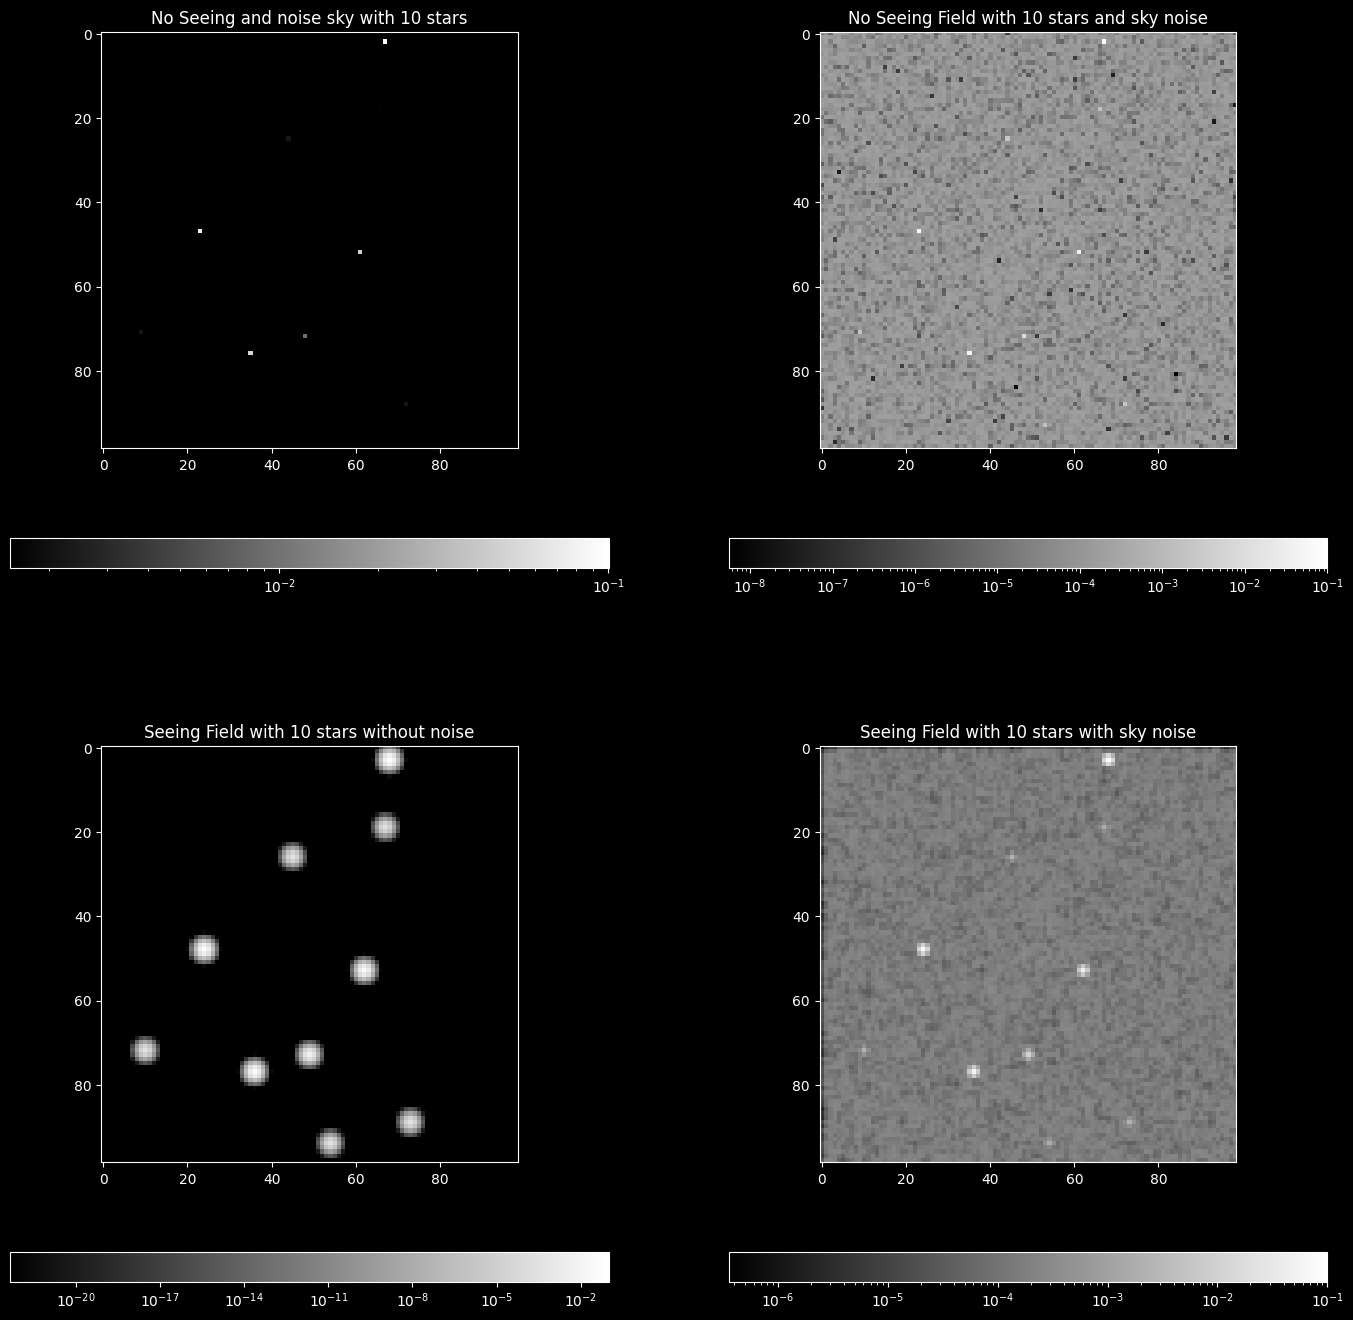

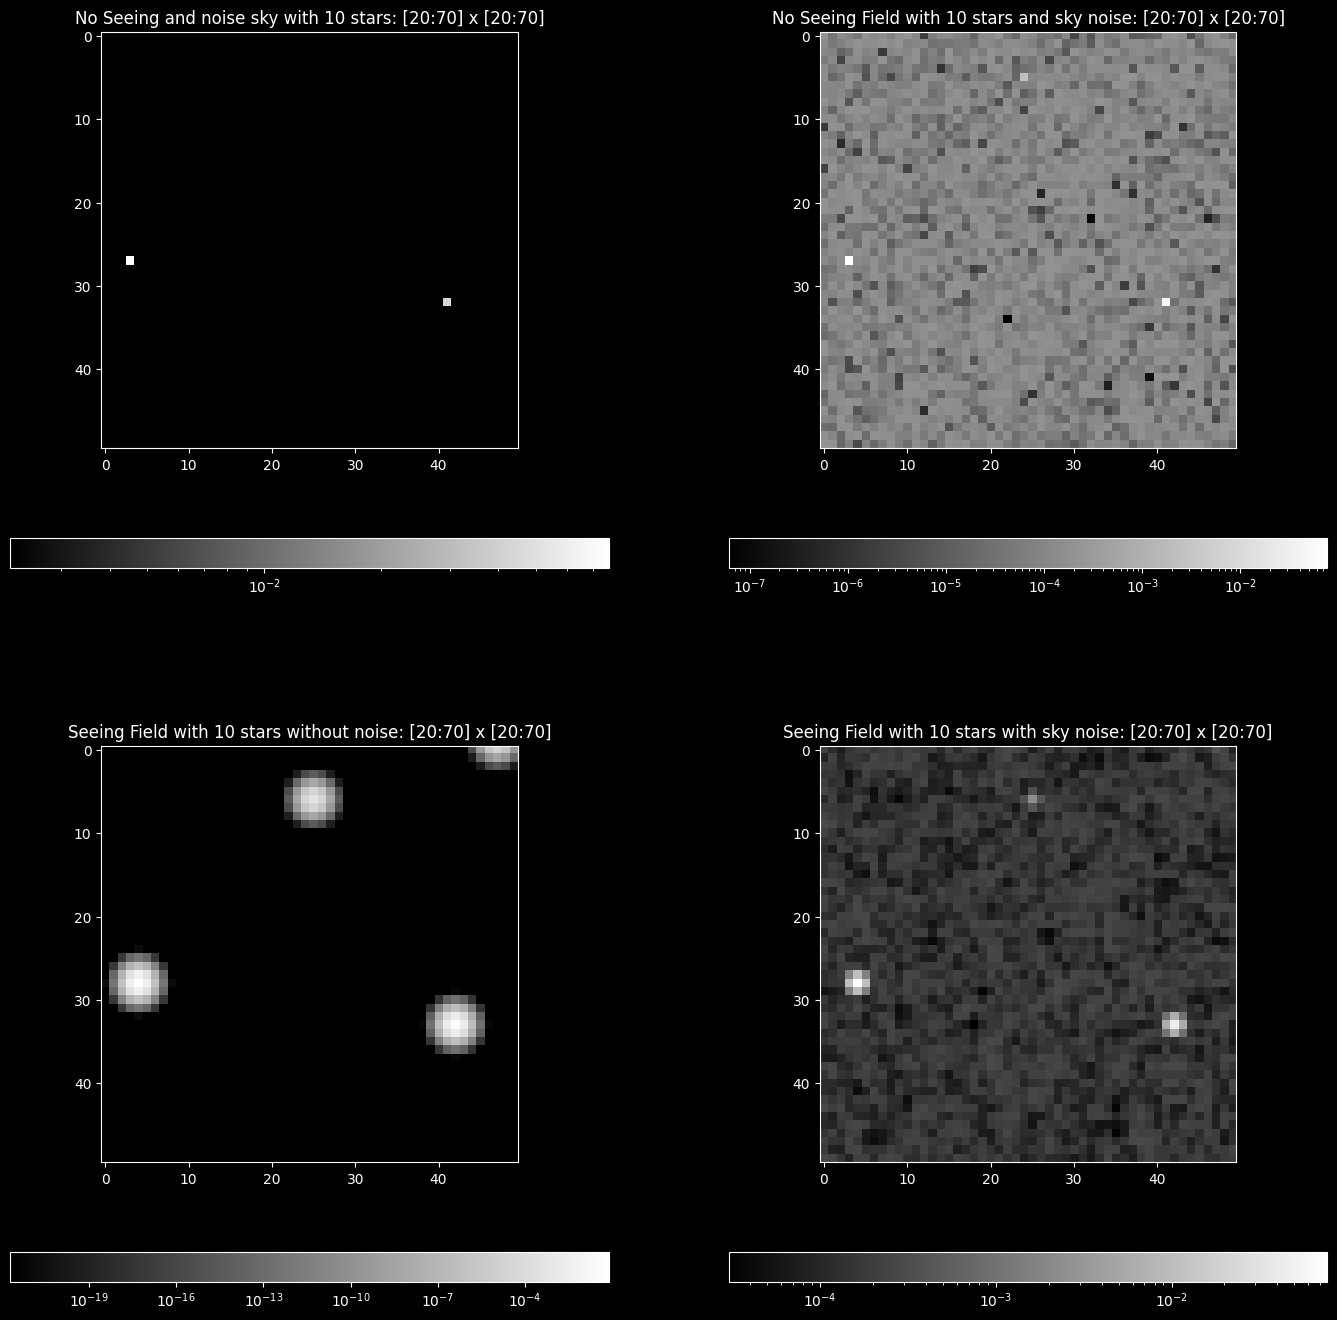

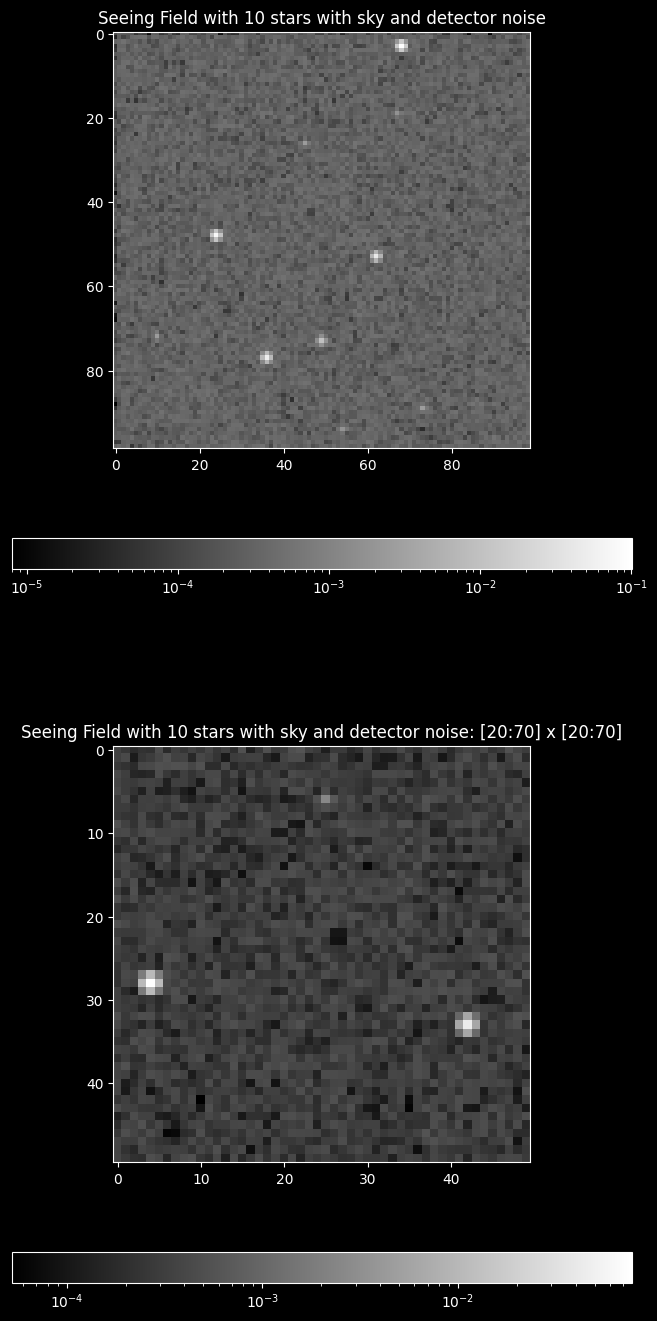

In [267]:
# SEVENTH CELL



##* 
def noise(n : float = 2e-4, dim : int = N) -> np.ndarray:
    """Noise generator
    It generates a (dim,dim) matrix of noise, using
    an arbitrary intensity n times
    a random value in [0,1]

    :param n: max intensity of noise, defaults to 2e-4
    :type n: float, optional
    :param dim: size of the field, defaults to N
    :type dim: int, optional

    :return: noise matrix
    :rtype: np.ndarray
    """
    np.random.seed()
    # random multiplicative (dim,dim) matrix
    N0 = np.random.random((dim, dim))*n
    return check_field(N0)


# generation of the field and the stars
F, S = initialize()


# add background noise
F_n = F + noise()


## Plot
fig1, ((img_field, img_field_noise),(img_field_seeing,img_field_snoise)) = plt.subplots(2,2,figsize=(17,17))
fig2, ((img_zoom, img_zoom_noise)  ,(img_zoom_seeing,img_zoom_snoise))   = plt.subplots(2,2,figsize=(17,17))
fig3, (img_field_tot, img_zoom_tot) = plt.subplots(2,1,figsize=(8,17))

#  0 : positive image
# -1 : negative image
v = 0

# detector noise
det_noise = 3e-4

field_image(fig1, img_field,F,v)
#img_field.imshow(1-F)
img_field.title.set_text(f'No Seeing and noise sky with {M} stars')
field_image(fig2, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.title.set_text(f'No Seeing and noise sky with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')


field_image(fig1, img_field_noise,F_n,v)
#img_field_noise.imshow(1-F_n)
img_field_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise')
field_image(fig2, img_zoom_noise,F_n,v,[inf,sup])
#img_zoom_noise.imshow(1-F_n[inf:sup,inf:sup,:])
img_zoom_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

# generate atmosferic seeing image without sky noise
F_s = atm_seeing(F)

field_image(fig1, img_field_seeing,F_s,v)
#img_field_seeing.imshow(1-F_s)
img_field_seeing.title.set_text(f'Seeing Field with {M} stars without noise')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
#img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars without noise: [{inf}:{sup}] x [{inf}:{sup}]')

# generate atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n)
field_image(fig1, img_field_snoise,F_sn,v)
#img_field_snoise.imshow(1-F_sn)
img_field_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise')
field_image(fig2, img_zoom_snoise,F_sn,v,[inf,sup])
#img_zoom_snoise.imshow(1-F_sn[inf:sup,inf:sup,:])
img_zoom_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

# add detector noise, set to 3e-4 (> than background one)
F_sn += noise(det_noise)
field_image(fig3, img_field_tot,F_sn,v)
#img_field_tot.imshow(1-F_sn)
img_field_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise')
field_image(fig3, img_zoom_tot,F_sn,v,[inf,sup])
#img_zoom_tot.imshow(1-F_sn[inf:sup,inf:sup,:])
img_zoom_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise: [{inf}:{sup}] x [{inf}:{sup}]')


fig1.savefig(os.path.join(picdir,'field_noise.png'))
fig2.savefig(os.path.join(picdir,'zoom_noise.png'))
fig3.savefig(os.path.join(picdir,'image.png'))

plt.show()


## II part: detect stars
### First cell

0.00015078222368372404


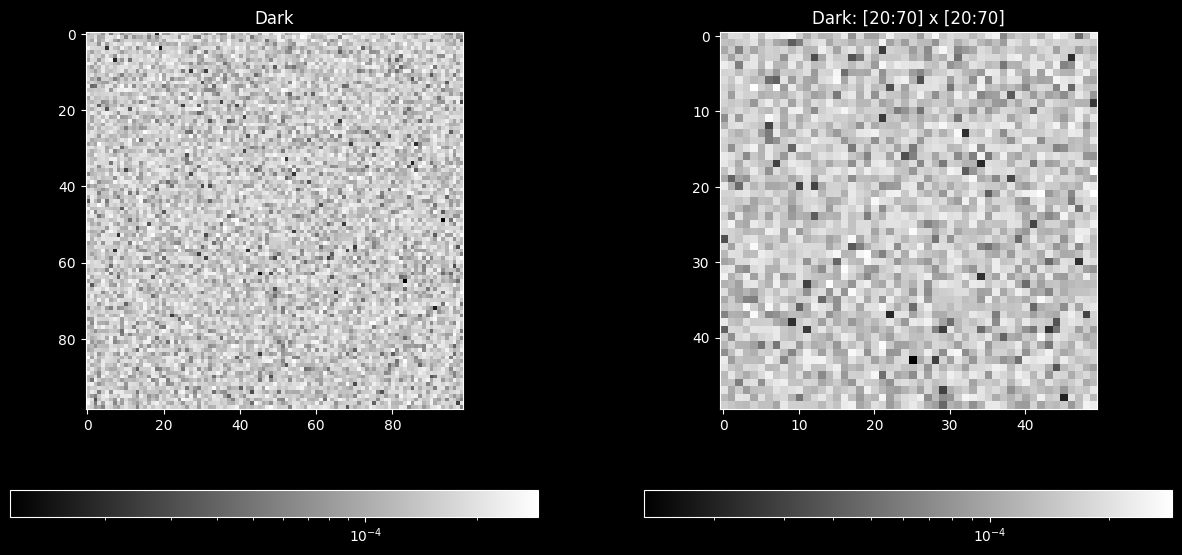

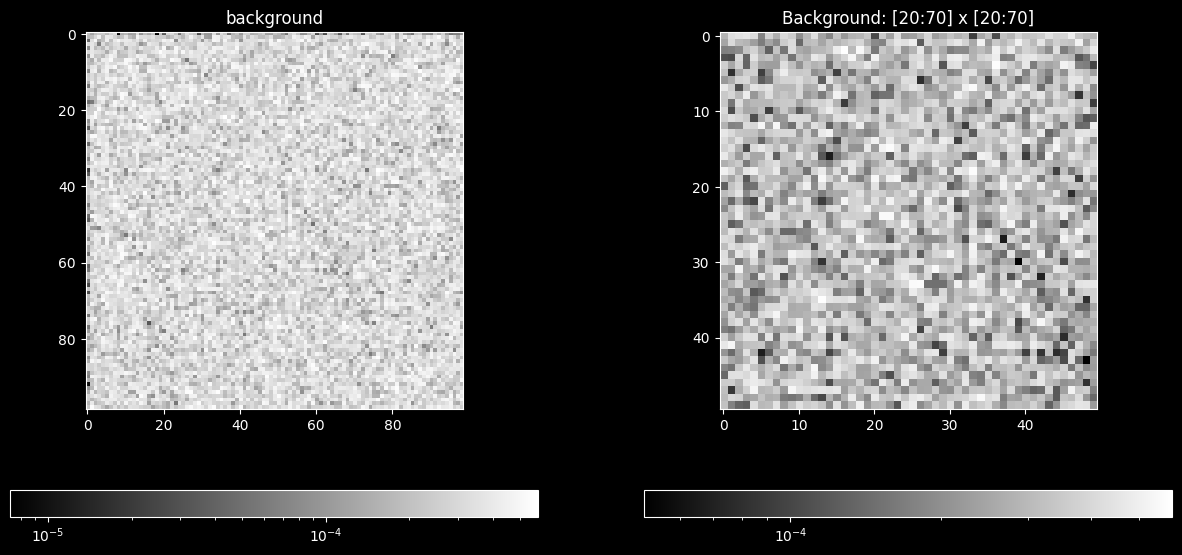

In [268]:
## First cell

# Dark

def dark_elaboration(n_value : float = 3e-4, iteration : int = 3) -> np.ndarray:
    dark = noise(n_value)
    for i in range(iteration-1):
        dark += noise(n_value)
    dark /= iteration
    return dark

dark = noise(3e-4)

d = dark.mean()

print(d)

d = dark
for i in range(2):
    d += noise(3e-4)

d /= 3


dark = d
# Background
bg  = atm_seeing(noise())
bg += noise(3e-4)

#bg-=dark

## Plot
fig1, (dark_img, dark_zoom) = plt.subplots(1,2,figsize=(15,7))
fig2, (bg_img, bg_zoom) = plt.subplots(1,2,figsize=(15,7))

#  0 : positive image
# -1 : negative image
v = 0

dark_img.set_title('Dark')
field_image(fig1, dark_img,dark,v)
#dark_img.imshow(dark)
dark_zoom.set_title(f'Dark: [{inf}:{sup}] x [{inf}:{sup}]')
field_image(fig1, dark_zoom,dark,v,[inf,sup])
#dark_zoom.imshow(dark[inf:sup,inf:sup,:])
bg_img.set_title('background')
field_image(fig2, bg_img,bg,v)
#bg_img.imshow(bg)
bg_zoom.set_title(f'Background: [{inf}:{sup}] x [{inf}:{sup}]')
field_image(fig2, bg_zoom,bg,v,[inf,sup])
#bg_zoom.imshow(bg[inf:sup,inf:sup,:])

plt.show()    

(array([ 0,  0,  0, ..., 99, 99, 99]), array([ 0,  3,  7, ..., 76, 90, 91]))
[0 0 0 0 0 0] [ 0  3  7  8 15 16]
0.5956130493830486
[8.20933065e-19 5.72430503e-19 9.06375483e-19 ... 3.26290595e-19
 3.27671529e-19 4.15432655e-19]
{8.209330650208542e-19: (0, 0), 5.724305030787974e-19: (0, 3), 9.063754833926102e-19: (0, 7), 9.181270781917674e-19: (0, 8), 2.876709635394641e-19: (0, 15), 4.526645726533499e-20: (0, 16), 1.576473438775226e-18: (0, 20), 8.534704683282753e-19: (0, 26), 6.790225991547275e-19: (0, 27), 6.736228906375845e-19: (0, 33), 1.2223754779432397e-18: (0, 39), 5.149920158362666e-19: (0, 44), 2.171975716462419e-19: (0, 47), 5.686975074286648e-19: (0, 49), 1.0965681684396744e-18: (0, 50), 2.521272731067289e-19: (0, 52), 7.564616068876314e-19: (0, 53), 1.0452038366882118e-18: (0, 56), 5.16035761819866e-19: (0, 57), 1.3527406605719227e-18: (0, 59), 1.610675217916011e-18: (0, 60), 1.0958473398996155e-18: (0, 61), 4.349400197623755e-19: (0, 62), 9.89085093316744e-19: (0, 67), 1.739

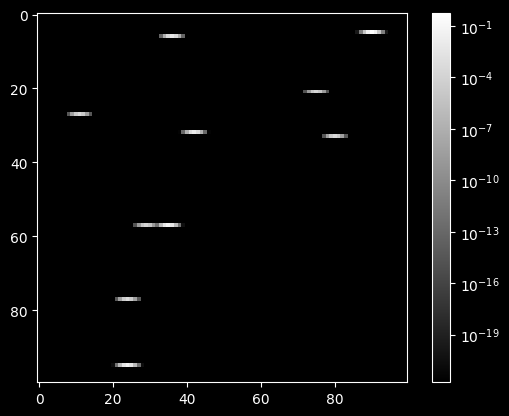

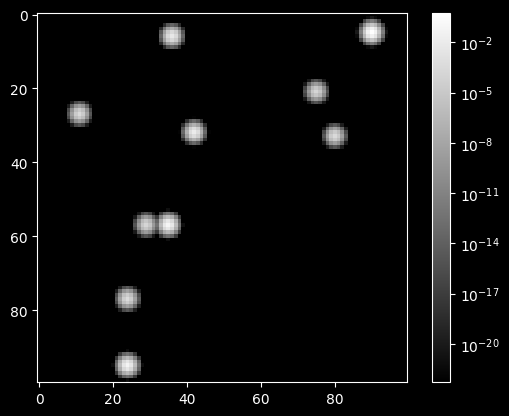

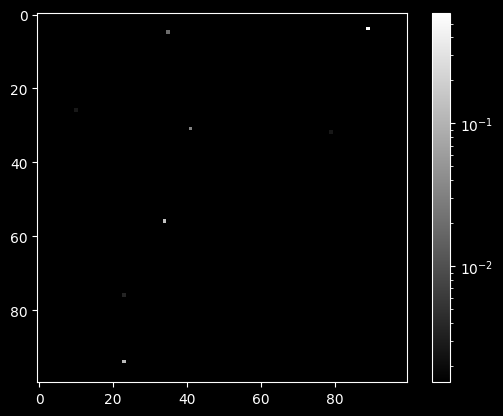

In [269]:
from scipy.signal import argrelextrema

# generation of the field and the stars
F, S = initialize()

# add background noise
F_n = F + noise()

# detector noise
det_noise = 3e-4

# generate atmosferic seeing image without sky noise
F_s = atm_seeing(F)

# generate atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n)

##* Detection
# set the field of interest
test_field = F_s #- dark_elaboration()

test_field = check_field(test_field)

# tuple with indicies of maxima for each row
ind = argrelextrema(test_field, np.greater, mode='wrap', axis=0)
x, y = ind
print(ind)
print(x[:6],y[:6])
print(max(S.lum))
print(test_field[ind])

# x, y = x[:10], y[:10]

# create an image to rappresent
test = np.zeros((N,N))
test[x,y] = test_field[x,y]

plt.figure(1)
plt.imshow(test, cmap='gray', norm='log')
plt.colorbar()
plt.figure(2)
plt.imshow(test_field, cmap='gray', norm='log')
plt.colorbar()
plt.figure(3)
plt.imshow(F, cmap='gray', norm='log')
plt.colorbar()

# make a dict to individuate maxima
# dict of indicies
maxima = { test_field[x[i],y[i]] : (x[i],y[i]) for i in range(len(x))}
print(maxima)

# sorted maxima
ordinated = np.sort(test_field[y,x])[::-1]

x1, y1 = maxima[ordinated[0]]

print(test_field[x1,:])
print(x1)

# create an image to rappresent
# tmp = np.zeros((N,N))
# for i in range(M):
#     tmp[maxima[ordinated[i]]] = ordinated[i]
#     print(maxima[ordinated[i]]) 

# plt.figure(4)
# plt.imshow(tmp, cmap='gray', norm='log')
# plt.colorbar()





# add detector noise, set to 3e-4 (> than background one)
F_sn += noise(det_noise)


plt.show()